<a href="https://colab.research.google.com/github/jpbianchi/corise/blob/main/FORECASTING/TIME_SERIES_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1

**Note**: if you feel like your Pandas skills need a bit of a touch up, check [this article out](https://levelup.gitconnected.com/20-pandas-functions-for-80-of-your-data-science-tasks-b610c8bfe63c)!

The dataset we're going to be using is one of the most realistic retail time-series datasets you'll find out there because, well, it's actual Walmart data. It was made available for a Kaggle competition that you can check out [here](https://www.kaggle.com/c/m5-forecasting-accuracy).

The original format of the data was in a "wide" format to made it smaller in memory, but that doesn't really work too well with databases and you won't see that very often in the real world. The most notable changes are that I added in a date column to replace the date identifier columns that were previously there, and I made the data smaller by only subsetting to the state of Texas.

**Another note:** If you want to develop and test your code with a smaller dataset (which I'd probably recommend), set `sampled` in the cell below to `True`. All of the tests will still pass if your code is correct!

Let's get into it!

In [ ]:
data_dir = 'data'
sampled = False #True

path_suffix = '' if not sampled else '_sampled'

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
!wget https://corise-ugc.com/static/course/forecasting-with-machine-learning/assets/cldkea2ch00e012as0qj38l98/data.zip
!unzip data.zip
!ls -al data/

--2023-03-18 19:33:38--  https://corise-ugc.com/static/course/forecasting-with-machine-learning/assets/cldkea2ch00e012as0qj38l98/data.zip
Resolving corise-ugc.com (corise-ugc.com)... 65.8.178.74, 65.8.178.69, 65.8.178.30, ...
Connecting to corise-ugc.com (corise-ugc.com)|65.8.178.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178517934 (170M) [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip            100%[===================>] 170.25M   105MB/s    in 1.6s    

2023-03-18 19:33:40 (105 MB/s) - ‘data.zip’ saved [178517934/178517934]

Archive:  data.zip
  inflating: data/sales_data.csv     
  inflating: data/transactions_data.csv  
total 1999216
drwxr-xr-x 2 root root       4096 Mar 18 19:33 .
drwxr-xr-x 1 root root       4096 Mar 18 19:33 ..
-rw-r--r-- 1 root root  928535251 Jan 23 09:51 sales_data.csv
-rw-r--r-- 1 root root 1118640783 Jan 23 09:46 transactions_data.csv


## Getting our data in the right format

Time-series data has to be collected from some real-world, data-generating process. That means that raw data comes in as a series of observations. Depending on your experience with time-series data, you may be used to data that looks like this:

| Date       | Sales |
|------------|-------|
| 2022-01-01 |  23   |
| 2022-01-02 |  45   |
| 2022-01-03 |  12   |
| 2022-01-04 |  67   |
| 2022-01-05 |  89   |

But, if you're in retail, each of those "sales" probably came in some JSON from some point-of-sale system (i.e. cash register) that probably looked something like this:

```
{
    "timestamp": 2022-01-01 12:34:56,
    "product_id": 5,
    "store_id": 12,
    "category_id": 36,
    ...
}
```

Usually, it's the job of a data engineer to collect all of these records and aggregate them into a nice, tabular format, but it's worth at least having an appreciation for how it's done. So, we're going to start from a mock version of a transactions table.

In [ ]:
transactions = pd.read_csv(f'{data_dir}/transactions_data{path_suffix}.csv')

transactions.head()

date                             id        item_id  \
0  2013-01-01 13:41:03  HOBBIES_1_004_TX_1_evaluation  HOBBIES_1_004   
1  2013-01-01 07:30:52  HOBBIES_1_004_TX_1_evaluation  HOBBIES_1_004   
2  2013-01-01 11:17:38  HOBBIES_1_004_TX_1_evaluation  HOBBIES_1_004   
3  2013-01-01 20:18:59  HOBBIES_1_025_TX_1_evaluation  HOBBIES_1_025   
4  2013-01-01 21:36:09  HOBBIES_1_028_TX_1_evaluation  HOBBIES_1_028   

     dept_id   cat_id store_id state_id  
0  HOBBIES_1  HOBBIES     TX_1       TX  
1  HOBBIES_1  HOBBIES     TX_1       TX  
2  HOBBIES_1  HOBBIES     TX_1       TX  
3  HOBBIES_1  HOBBIES     TX_1       TX  
4  HOBBIES_1  HOBBIES     TX_1       TX

In [ ]:
transactions.dtypes

date        object
id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
state_id    object
dtype: object

You can see that this is a DataFrame where each row relates to purchases for an individual item. Here's a little data dictionary:

- `date`: the time at which an item was bought, down to the second
- `id`: the product ID. Each of these is an individual item at a specific store.
- `item_id`: this is an identifier for items, but not at the store level. You can use this to find the same item at different stores.
- `dept_id`: department ID. One level up from `item_id` in the hierarchy
- `cat_id`: category ID. One level up from `dept_id` in the hierarchy
- `store_id`: identifies the specific store where the product was bought
- `state_id`: identifies the specific state where the product was bought

`date` is supposed to be a `datetime`-like object, but you can see that when we loaded it from disk, it was loaded in as a string. Let's convert that column to `datetime`.

In [ ]:
# QUESTION: Convert this column to a datetime object
transactions['date'] = pd.to_datetime(transactions.date) #, format="%Y-%m-%d %H:%M:%S")
transactions.dtypes

date        datetime64[ns]
id                  object
item_id             object
dept_id             object
cat_id              object
store_id            object
state_id            object
dtype: object

Our goal is to transform this dataset into one that's easy to analyze and train models on. For this project, our goal is going to be to work at the daily level. So, our first step is to aggregate our transactions data up to the daily level.

To be more specific, this is what we want it to look like:

In [ ]:
# This is a hefty table, so just peeking at the first 5 rows
pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', nrows=5)

date                               id          item_id      dept_id  \
0  2013-01-01    HOBBIES_1_004_TX_1_evaluation    HOBBIES_1_004    HOBBIES_1   
1  2013-01-01    HOBBIES_2_075_TX_1_evaluation    HOBBIES_2_075    HOBBIES_2   
2  2013-01-01  HOUSEHOLD_1_247_TX_1_evaluation  HOUSEHOLD_1_247  HOUSEHOLD_1   
3  2013-01-01  HOUSEHOLD_1_266_TX_1_evaluation  HOUSEHOLD_1_266  HOUSEHOLD_1   
4  2013-01-01      FOODS_1_001_TX_1_evaluation      FOODS_1_001      FOODS_1   

      cat_id store_id state_id  sales  
0    HOBBIES     TX_1       TX      3  
1    HOBBIES     TX_1       TX      0  
2  HOUSEHOLD     TX_1       TX      0  
3  HOUSEHOLD     TX_1       TX      0  
4      FOODS     TX_1       TX      0

You can see that the `sales` column is really just a daily count of transactions for that particular `id`.

In the cell below, create a dataframe called `data`, which is the transactions dataframe aggregated to the daily level. It should look like the above, except you won't have zero sales days. Don't worry about order: the below test will handle that!

In [ ]:
%%timeit -n 1

skiprows = 1  # <<< WE SKIP ALL ROWS except those where row % skiprows == 0 ie we divide the nb of rows by skiprows
data = pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', skiprows=lambda r: r%skiprows, usecols=['date','id','sales'])
data['date'] = pd.to_datetime(data.date) #, format="%Y-%m-%d %H:%M:%S")
data = data.loc[data['sales'] != 0]
data = data.groupby(['date', 'id']).sum()
data = data.reset_index()
data.head()

17.5 s ± 873 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895938 entries, 0 to 3895937
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   id      object        
 2   sales   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 377.3 MB


If the cell below runs without error, you did it right!

In [ ]:
def test_sales_eq(data):
    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'], skiprows=lambda r: r%skiprows)
        .assign(date=lambda df: pd.to_datetime(df.date))
        .query('sales != 0')
        .merge(data, on=['date', 'id'], how='left', suffixes=('_actual', '_predicted'))
        .fillna(0)  # because of the left join, some sales may be missing if data df is wrong
        .assign(sales_error=lambda df: (df.sales_actual - df.sales_predicted).abs())
        .sales_error
        .sum() < 1e-6
    ), 'Your version of sales does not match the original sales data.'

    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'], skiprows=lambda r: r%skiprows)
        .query('sales != 0')
        .shape[0]
    ) == data.shape[0], 'Your dataframe has a different number of rows than the original sales data.'

    print('Test passed!')

test_sales_eq(data)

Test passed!


## Optimizing our data

Let's take a look at how our data is being stored in memory.

In [ ]:
data.head()

date                           id  sales
0 2013-01-01  FOODS_1_004_TX_1_evaluation     20
1 2013-01-01  FOODS_1_004_TX_2_evaluation     20
2 2013-01-01  FOODS_1_004_TX_3_evaluation      4
3 2013-01-01  FOODS_1_005_TX_2_evaluation      1
4 2013-01-01  FOODS_1_009_TX_2_evaluation      3

In [ ]:
# some tests to play with pandas
print(len(data.id))
print(data.loc[data['id'].str.contains('evaluation')].id.__len__())
print(data.loc[data['id'].str.contains('TX')].id.__len__())
print(data.loc[~data['id'].str.contains('FOODS')].id.__len__())
# even if TX is in all ids here, it's not wise to remove the State information
print("We can remove 'evaluation' from the id column, but not the first word (FOODS, HOBBIES, HOUSEHOLD)")
data.id.str.split('_', expand=True)[[0,1,2,3,4]].apply('_'.join, axis=1)


3895938
3895938
3895938
1768518
We can remove 'evaluation' from the id column, but not the first word (FOODS, HOBBIES, HOUSEHOLD)


0              FOODS_1_004_TX_1
1              FOODS_1_004_TX_2
2              FOODS_1_004_TX_3
3              FOODS_1_005_TX_2
4              FOODS_1_009_TX_2
                   ...         
3895933    HOUSEHOLD_2_511_TX_3
3895934    HOUSEHOLD_2_513_TX_1
3895935    HOUSEHOLD_2_514_TX_3
3895936    HOUSEHOLD_2_516_TX_2
3895937    HOUSEHOLD_2_516_TX_3
Length: 3895938, dtype: object

In [ ]:
data.head()
len(data)

3895938

In [ ]:
skiprows = 1
data = (pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'], skiprows=lambda r: r%skiprows)
        .assign(date=lambda df: df.date.str[:10],  # get rid of time of day, or groupby wont work, then str (we could have taken first 10 chars...)
                id=lambda df: df.id.astype("category"))  # we can save memory by using a category
        # .fillna(0) # this makes an error on Colab and Kaggle, but not on VSCode
        .groupby(['date', 'id'])  # >>> date and id are now indices
        .sum()
        .fillna(0)
        .query('sales != 0')
        # .set_index(['date','id'])  # error because groupby has already transformed date and id into index
        .sort_index()
        # .reset_index()
        )

compressed_memory = data.memory_usage(deep=True).sum()
print(f'Memory used: {compressed_memory // 1e6:,} MB')
print(f"Memory reduction = {1 - compressed_memory / 15e8:.1%}")
data.head(10)

Memory used: 47.0 MB
Memory reduction = 96.8%


sales
date       id                                
2013-01-01 FOODS_1_004_TX_1_evaluation     20
           FOODS_1_004_TX_2_evaluation     20
           FOODS_1_004_TX_3_evaluation      4
           FOODS_1_005_TX_2_evaluation      1
           FOODS_1_009_TX_2_evaluation      3
           FOODS_1_012_TX_1_evaluation      2
           FOODS_1_012_TX_2_evaluation      3
           FOODS_1_013_TX_3_evaluation      3
           FOODS_1_014_TX_3_evaluation      2
           FOODS_1_015_TX_2_evaluation      1

1.5 GB of data for our purposed is certainly no joke. But how much of that is really necessary?

Most of our data is stored in the least memory efficient format for pandas: strings (objects). Let's fix that.

Hint: check out [this page](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes) of the pandas documentation that talks about data types.

In the below cell, convert the data types of columns to reduce memory usage as much as possible.

In my solution, I got the final DataFrame down to 90.4 MB, which is about 6% of the original size!

While we're at it, it's worth talking about the best way to store this data on disk. If we saved this as a CSV, it wouldn't maintain any of the data type modifications we just made. Pandas offers a bunch of options for saving DataFrames, but here are the two I'd recommend:

- [Parquet](https://pandas.pydata.org/docs/dev/reference/api/pandas.DataFrame.to_parquet.html) has basically become the industry standard for storing tabular data on disk. It's a columnar file format that automatically compresses your data (which it does really well) and will maintain any data types you use in Pandas, with only a couple exceptions.

- [Feather](https://pandas.pydata.org/docs/dev/reference/api/pandas.DataFrame.to_parquet.html) is also a columnar data format, but it optimizes heavily for read speed. Your file size will be much bigger than Parquets, but it's really useful when you need to heavily optimize for data reading.

In [ ]:
data.to_parquet('sales_data_checkpoint.parquet')

In [ ]:
data = pd.read_parquet('sales_data_checkpoint.parquet')

In [ ]:
data.to_feather('sales_data_checkpoint.feather')
data = pd.read_feather('sales_data_checkpoint.feather')

In [ ]:
data.info(memory_usage='deep')

On my local machine, loading our original CSV took ~8.7 seconds, and that only took 0.1 seconds. And our data types were maintained! Nice!

## Finishing up our data pre-processing

There's one last modification we need to make to our data before it's ready to go. The way that we converted transactions into sales was *slightly* problematic because now, when a product doesn't sell it just isn't present in our data, rather than appearing as a zero.

That's an issue for our forecasting models, so let's fix it!

First, set your index to columns that the DataFrame is distinct on (`date` and `id`).

In [ ]:
data = ...  # this was already done by the .groupby(['date', 'id']).sum() above

Now, create a MultiIndex with all combinations of daily dates and `id`s using `pd.MultiIndex.from_product`

In [ ]:
# Your code here

index_to_select = pd.MultiIndex.from_product([data.index.levels[0], data.index.levels[1]], names=['date', 'id'])
index_to_select

MultiIndex([('2013-01-01',     'FOODS_1_001_TX_1_evaluation'),
            ('2013-01-01',     'FOODS_1_001_TX_2_evaluation'),
            ('2013-01-01',     'FOODS_1_001_TX_3_evaluation'),
            ('2013-01-01',     'FOODS_1_002_TX_1_evaluation'),
            ('2013-01-01',     'FOODS_1_002_TX_2_evaluation'),
            ('2013-01-01',     'FOODS_1_002_TX_3_evaluation'),
            ('2013-01-01',     'FOODS_1_003_TX_1_evaluation'),
            ('2013-01-01',     'FOODS_1_003_TX_2_evaluation'),
            ('2013-01-01',     'FOODS_1_003_TX_3_evaluation'),
            ('2013-01-01',     'FOODS_1_004_TX_1_evaluation'),
            ...
            ('2016-05-22', 'HOUSEHOLD_2_513_TX_3_evaluation'),
            ('2016-05-22', 'HOUSEHOLD_2_514_TX_1_evaluation'),
            ('2016-05-22', 'HOUSEHOLD_2_514_TX_2_evaluation'),
            ('2016-05-22', 'HOUSEHOLD_2_514_TX_3_evaluation'),
            ('2016-05-22', 'HOUSEHOLD_2_515_TX_1_evaluation'),
            ('2016-05-22', 'HOUSEHOLD_2

Finally, fill the resulting `NaN`s in your dataframe. Hint: it's tempting to use `.groupby().fillna(method='ffill')` (and backfilling), but unfortunately this method is quite slow on grouped data. I'd recommend manually recreating the categorical columns by splitting the `id` column on underscores. This cell could take over a minute to run depending on how you implement it!

In [ ]:
data = data.reindex(index_to_select)

data.info(memory_usage='deep')

data.head(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11323986 entries, ('2013-01-01', 'FOODS_1_001_TX_1_evaluation') to ('2016-05-22', 'HOUSEHOLD_2_516_TX_3_evaluation')
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   sales   float64
dtypes: float64(1)
memory usage: 130.9 MB


sales
date       id                                
2013-01-01 FOODS_1_001_TX_1_evaluation    NaN
           FOODS_1_001_TX_2_evaluation    NaN
           FOODS_1_001_TX_3_evaluation    NaN
           FOODS_1_002_TX_1_evaluation    NaN
           FOODS_1_002_TX_2_evaluation    NaN
           FOODS_1_002_TX_3_evaluation    NaN
           FOODS_1_003_TX_1_evaluation    NaN
           FOODS_1_003_TX_2_evaluation    NaN
           FOODS_1_003_TX_3_evaluation    NaN
           FOODS_1_004_TX_1_evaluation   20.0

In [ ]:
def test_sales_eq(data):
    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'])
        .assign(date=lambda df: df.date.str[:10])  # modified df.datetime... to match what I did earlier
        .merge(data, on=['date', 'id'], how='left', suffixes=('_actual', '_predicted'))
        .fillna(0)
        .assign(sales_error=lambda df: (df.sales_actual - df.sales_predicted).abs())
        .sales_error
        .sum() < 1e-6
    ), 'Your version of sales does not match the original sales data.'
    print("Test passed!")

test_sales_eq(data)

Test passed!


## Exploring our data

Exploratory data analysis is crucial for building the best models.

Before you start this section, though, I would **highly recommend** that you set the index of your DataFrame to be on both the `date` and `id` field (our DataFrame has one row for each `date`/`id` combo). It's up to you, but it's good practice!

For this section, find 3-5 insights about the data that you feel are helpful for building models. Specifically, we'll be building models at the `date`/`dept_id` level (i.e., a forecast for `FOODS_1` on 2011-02-01, 2011-02-02, etc., a forecast for `HOBBIES_1` on 2011-02-01, 2011-02-02, etc.)

The only required one is an [autocorrelation analysis](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html). Other than that, some ideas are:

- Looking for seasonal patterns and trends for each department
- Department sales by day of week
- Analyses at a higher level, like the category level

Anything goes! Be creative!

Here's an example of plotting the category-level sales for `FOODS_1` to get you started:

```
(
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'FOODS_1']
    .plot()
)
```

In [ ]:
# some tests with splitting the index into columns
data3 = {'date': ['2022-01-01', '2022-01-01', '2022-01-02', '2022-01-02'],
        'id': ['A,B', 'C,D', 'E,F', 'G,H'],
        'values': [1, 2, 3, 4]}
df2 = pd.DataFrame(data3).set_index(['date', 'id'])
print(df2)

# Split the 'id' level of the index on ',' and create a MultiIndex with two levels
split_ids = [id.split(',') for id in df2.index.get_level_values('id')]
split_ids = df2.index.get_level_values('id').str.split(",", expand=True)
# print(*split_ids)
# df2.set_index([df2.index.get_level_values('date'), df2.index.get_level_values('id').str.split(",", expand=True)])#, names=['date', 'id_1', 'id_2'])
# df2.set_index([df2.index.get_level_values('id').str.split(",", expand=True)])
# df2.rename(index=df2.index.get_level_values('id').str.split(","))
# new_index = df2.index.get_level_values('id').to_series().str.split(",", expand=True)
df2['id2'] = df2.index.get_level_values('id')
# df2 = df2.id2.str.split(",", expand=True)
# df2.index.drop('id')
# df2.id2.str.split(",", expand=True)
# dates = df2.index.get_level_values('date')
# print(dates)
# idx = pd.MultiIndex.from_arrays([dates,[*split_ids]], names=['date', 'id_1'])
# print(idx)
# # print(new_index)
# df2 = df2.reindex(idx)
df2[['id_1', 'id_2']] = df2.id2.str.split(",", expand=True)
df2=df2.reset_index(level='id', drop=True)  # removes index level 'id'
df2.set_index([df2.index.get_level_values('date'),'id_1', 'id_2'],inplace=True)
df2.drop('id2', axis=1, inplace=True)

print(df2)
# print(df2.columns)

                values
date       id         
2022-01-01 A,B       1
           C,D       2
2022-01-02 E,F       3
           G,H       4
                      values
date       id_1 id_2        
2022-01-01 A    B          1
           C    D          2
2022-01-02 E    F          3
           G    H          4


In [ ]:
# we regenerate the fields from the id index

data['id2']=data.index.get_level_values('id')  # bring id back as a column so we can split it in various columns
data[['cat_id', 'dept_id', 'item_id','state','store_id','stage']] = data.id2.str.split("_", expand=True)

data.reset_index(level='id', drop=True, inplace=True)  # removes index level 'id'
data.drop('id2', axis=1, inplace=True)  # drops column id2 we don't need anymore
# sends those columns as indices to easily select the items we want
data.set_index([data.index.get_level_values('date'), 'cat_id', 'dept_id', 'item_id','state','store_id','stage'], inplace=True)
# careful: now, to get dept_id FOODS_1, one needs to use [:,'FOODS','1'] instead of [:,'FOODS_1']

data.head()

#    date	                id	                            item_id	    dept_id	    cat_id	store_id	state_id
# 0	2013-01-01 13:41:03	HOBBIES_1_004_TX_1_evaluation	HOBBIES_1_004	HOBBIES_1	HOBBIES	TX_1	    TX

sales
date       cat_id dept_id item_id state store_id stage            
2013-01-01 FOODS  1       001     TX    1        evaluation    NaN
                                        2        evaluation    NaN
                                        3        evaluation    NaN
                          002     TX    1        evaluation    NaN
                                        2        evaluation    NaN

In [ ]:
data2=data.copy()

In [ ]:
data=data2

<Axes: title={'center': 'FOODS'}, xlabel='date', ylabel='FOODS'>

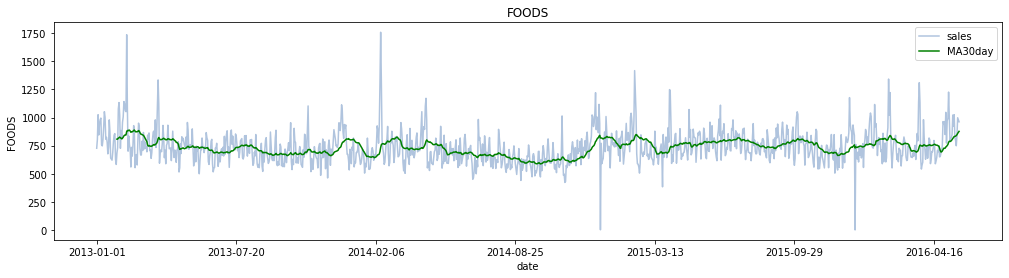

In [ ]:
(
    data #[:100000]
    .dropna()
    .loc[:, 'FOODS','1'] # this disappears all indices except date
    .groupby(['date'])
    # .agg(['sum', lambda x: x.rolling(window=30, min_periods = 1).mean()])
    .sales
    .sum()  # now we have a series with date as index
    # [:, 'FOODS','FOODS_1']  # not to be used if we used .loc above
    .to_frame(name='sales')  # we must recreate a DF to be able to .assign a new column (sum() gives a Series)

    .assign(MA30day=lambda df: df.sales.rolling(30, min_periods = 30).mean())

    [['sales', 'MA30day']]  # not necessary since there's only 2 columns, but, for the record, that's how we pot two columns of a DF
    .plot(legend=True, color = ['lightsteelblue','green'], ylabel='FOODS', title='FOODS', subplots=False, figsize=(17,4))
)

<Axes: title={'center': 'HOBBIES'}, xlabel='date', ylabel='sales'>

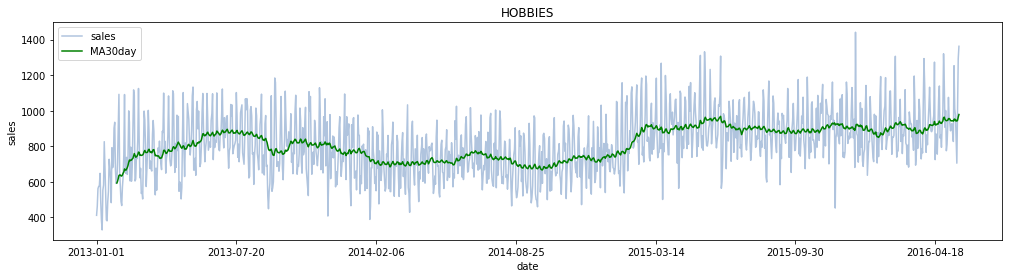

In [ ]:
(
    data #[:100000]
    .dropna()
    .loc[:, 'HOBBIES','1']
    .groupby(['date'])
    .sales
    .sum()
    .to_frame(name='sales')
    .assign(MA30day=lambda df: df.sales.rolling(30, min_periods = 30).mean())
    .plot(legend=True, color = ['lightsteelblue','green'], ylabel='sales', title='HOBBIES', subplots=False, figsize=(17,4))
)

In [ ]:
cat_sales = data.dropna().groupby(['date', 'cat_id', 'dept_id']).sales.sum()

In [ ]:
# let's see what we have, looks good, no need to order the index
cat_sales

date        cat_id     dept_id
2013-01-01  FOODS      1           727.0
                       2           892.0
                       3          4230.0
            HOBBIES    1           412.0
                       2            37.0
                                   ...  
2016-05-22  FOODS      3          7110.0
            HOBBIES    1          1362.0
                       2           181.0
            HOUSEHOLD  1          3018.0
                       2           754.0
Name: sales, Length: 8651, dtype: float64

In [ ]:
cat_sales[:,'HOBBIES','1']

date
2013-01-01     412.0
2013-01-02     462.0
2013-01-03     562.0
2013-01-04     574.0
2013-01-05     579.0
               ...  
2016-05-18     842.0
2016-05-19     705.0
2016-05-20    1006.0
2016-05-21    1292.0
2016-05-22    1362.0
Name: sales, Length: 1235, dtype: float64

In [ ]:
categories = list((data.index.get_level_values('cat_id') + '_' + data.index.get_level_values('dept_id')).unique())
categories


['FOODS_1',
 'FOODS_2',
 'FOODS_3',
 'HOBBIES_1',
 'HOBBIES_2',
 'HOUSEHOLD_1',
 'HOUSEHOLD_2']

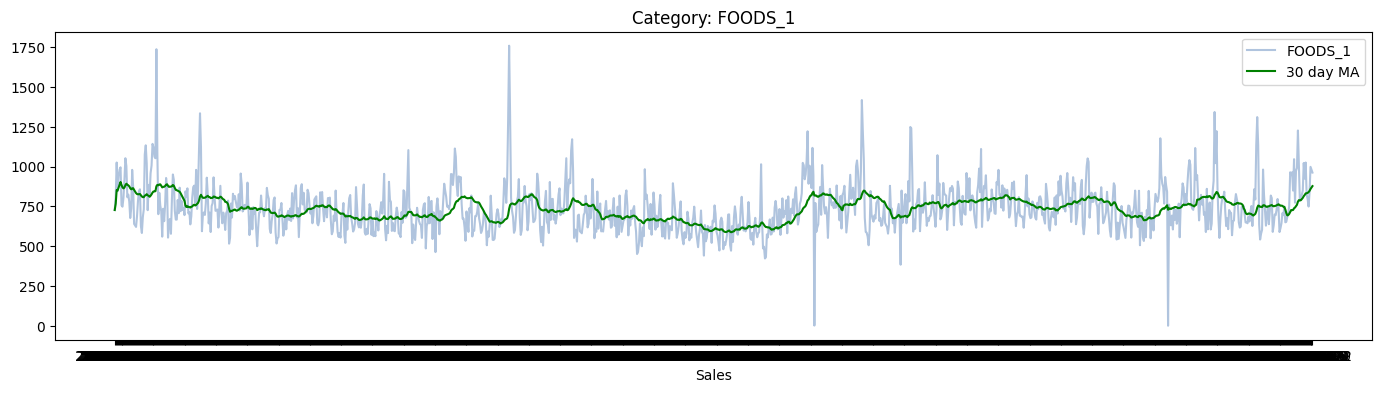

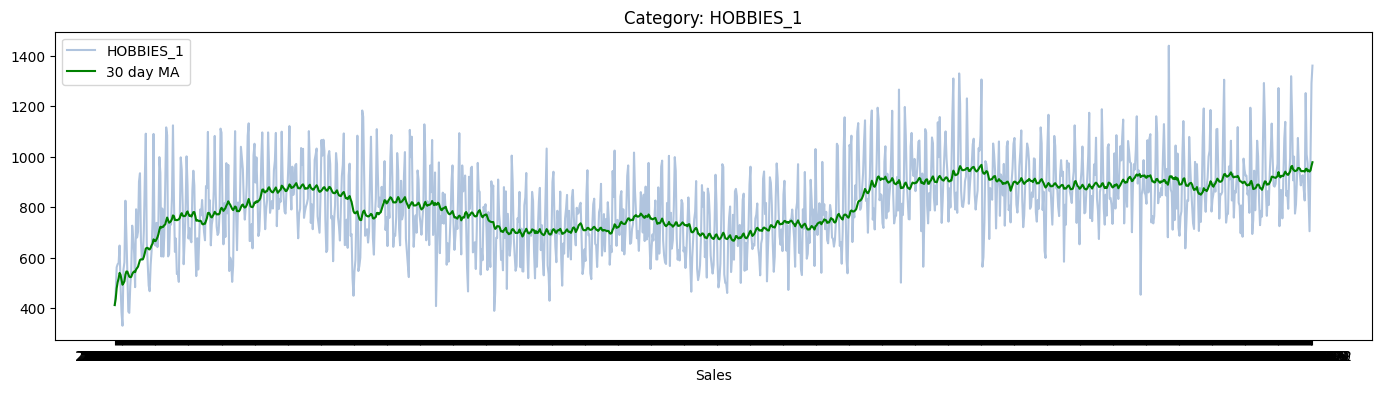

In [ ]:
for catn in ['FOODS_1', 'HOBBIES_1']:
    cat,n = catn.strip().split('_')
    fig, ax = plt.subplots(figsize=(17, 4))

    ax.plot(cat_sales[:,cat,n], color = 'lightsteelblue', label = f'{cat}_{n}')
    ax.plot(cat_sales[:,cat,n].rolling(30, min_periods = 1).mean(), color='green', label = '30 day MA')

    ax.set_title(f'Category: {cat}_{n}')
    ax.set_xlabel('Sales')
    ax.legend()
    plt.show()

In [ ]:
# let's make things easier and concatenate cat_id and dept_id to get the dept_id the code below expects ('FOODS_1')
df2 = data[7:50].copy()
print(df2.head())

df2.index = pd.MultiIndex.from_tuples([(x[0], x[1], x[1]+'_'+ x[2],'_'.join(x[1:4]), x[4], x[5], x[6]) for x in df2.index], names=['date', 'cat_id', 'dept_id', 'item_id', 'state', 'store_id', 'stage'])
# df2.index.set_levels(df2.index.levels[df2.index.names.index('cat_id')] + '_' + df2.index.levels[df2.index.names.index('dept_id')], level='dept_id', inplace=True) # also works
# df2.index.set_levels(df2.index.get_level_values('cat_id') + '_' + df2.index.get_level_values('dept_id'), level='dept_id', inplace=True)
print(df2.head())

                                                             sales
date       cat_id dept_id item_id state store_id stage            
2013-01-01 FOODS  1       003     TX    2        evaluation    NaN
                                        3        evaluation    NaN
                          004     TX    1        evaluation   20.0
                                        2        evaluation   20.0
                                        3        evaluation    4.0
                                                                 sales
date       cat_id dept_id item_id     state store_id stage            
2013-01-01 FOODS  FOODS_1 FOODS_1_003 TX    2        evaluation    NaN
                                            3        evaluation    NaN
                          FOODS_1_004 TX    1        evaluation   20.0
                                            2        evaluation   20.0
                                            3        evaluation    4.0


In [ ]:
# let's make things easier and concatenate cat_id and dept_id to get the dept_id the code below expects ('FOODS_1')
data.index = pd.MultiIndex.from_tuples([(x[0], x[1], x[1]+'_'+ x[2],'_'.join(x[1:4]), x[4], x[5], x[6]) for x in data.index],
                                       names=['date', 'cat_id', 'dept_id', 'item_id', 'state', 'store_id', 'stage'])
data.head(3)

In [ ]:

dept_sales = data.groupby(['date', 'dept_id']).sales.sum().unstack('dept_id').fillna(0)

# Resample data to get weekly and daily sales data for each department
dept_sales.rename(index=lambda d: pd.to_datetime(d), level='date' ,inplace=True)  # convert index back to datetime because resample needs it

monthly_sales = dept_sales.resample('M').sum()
daily_sales = dept_sales.resample('D').sum()
quarterly_sales = dept_sales.resample('Q').sum()

departments = list(data.index.get_level_values('dept_id').unique())
print("Departments:", departments)

Departments: ['1', '2', '3']


In [ ]:
daily_sales

dept_id          1       2       3
date                              
2013-01-01  2905.0  1199.0  4230.0
2013-01-02  3278.0  1317.0  3792.0
2013-01-03  3752.0  1606.0  4711.0
2013-01-04  3530.0  1348.0  3983.0
2013-01-05  3898.0  1704.0  5708.0
...            ...     ...     ...
2016-05-18  3761.0  1786.0  4828.0
2016-05-19  3299.0  1643.0  4220.0
2016-05-20  4551.0  1912.0  5840.0
2016-05-21  4992.0  2233.0  6456.0
2016-05-22  5342.0  2363.0  7110.0

[1238 rows x 3 columns]

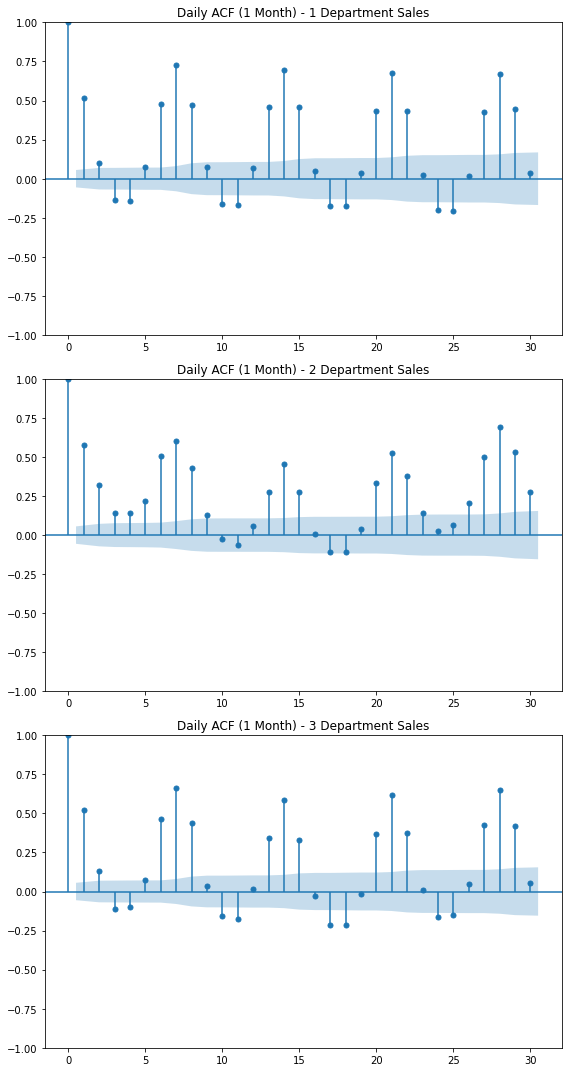

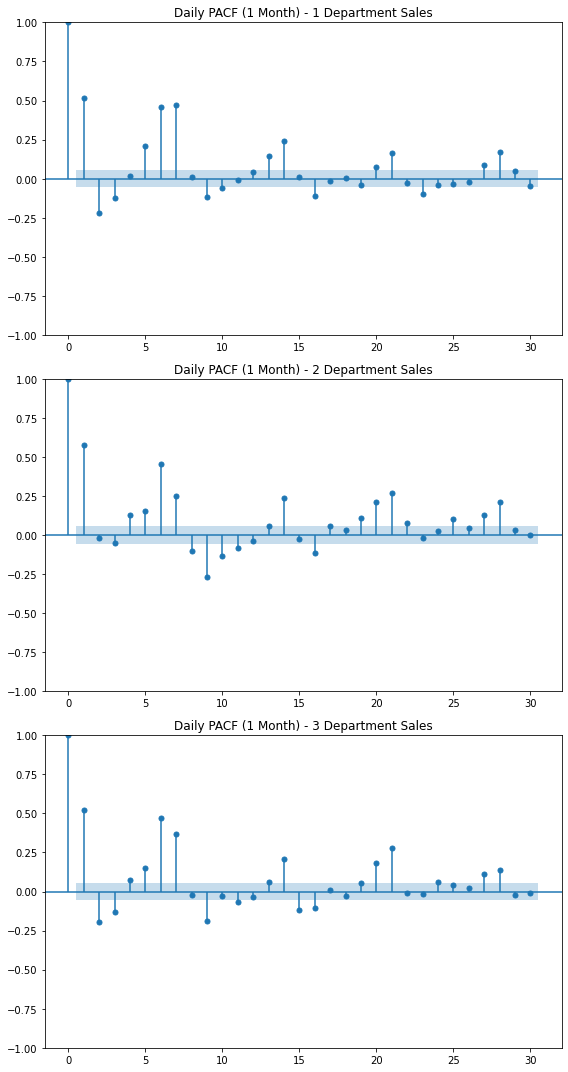

In [ ]:
# DAILY AUTOCORRELATIONS for all departments
fig, axs = plt.subplots(len(departments), 1, figsize=(8, 15))
for i, dept in enumerate(departments):
    plot_acf(daily_sales[dept], ax=axs[i], lags=30)
    axs[i].set_title('Daily ACF (1 Month) - {} Department Sales'.format(dept))
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(len(departments), 1, figsize=(8, 15))
for i, dept in enumerate(departments):
    plot_pacf(daily_sales[dept], ax=axs[i], lags=30, method='ywm')
    axs[i].set_title('Daily PACF (1 Month) - {} Department Sales'.format(dept))
plt.tight_layout()
plt.show()

Here's what TIMO BOUZIAN GETS (LEARN FROM HIS NB)
https://www.kaggle.com/jpbianchi/time-series-p1-timo-bouzian/edit

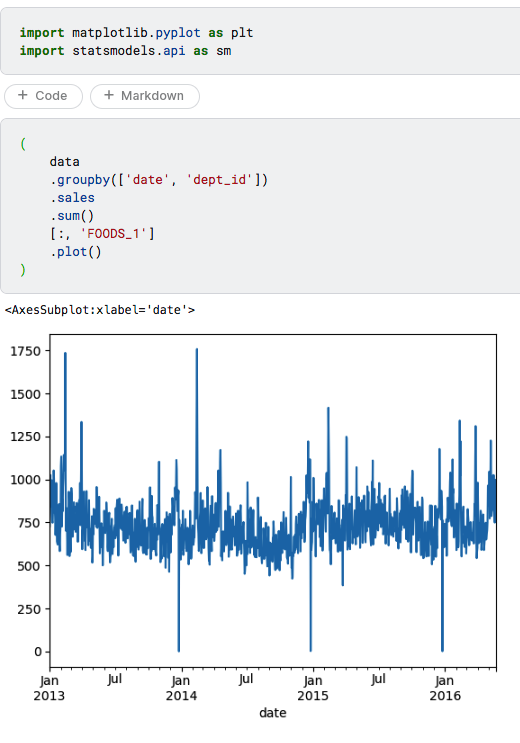

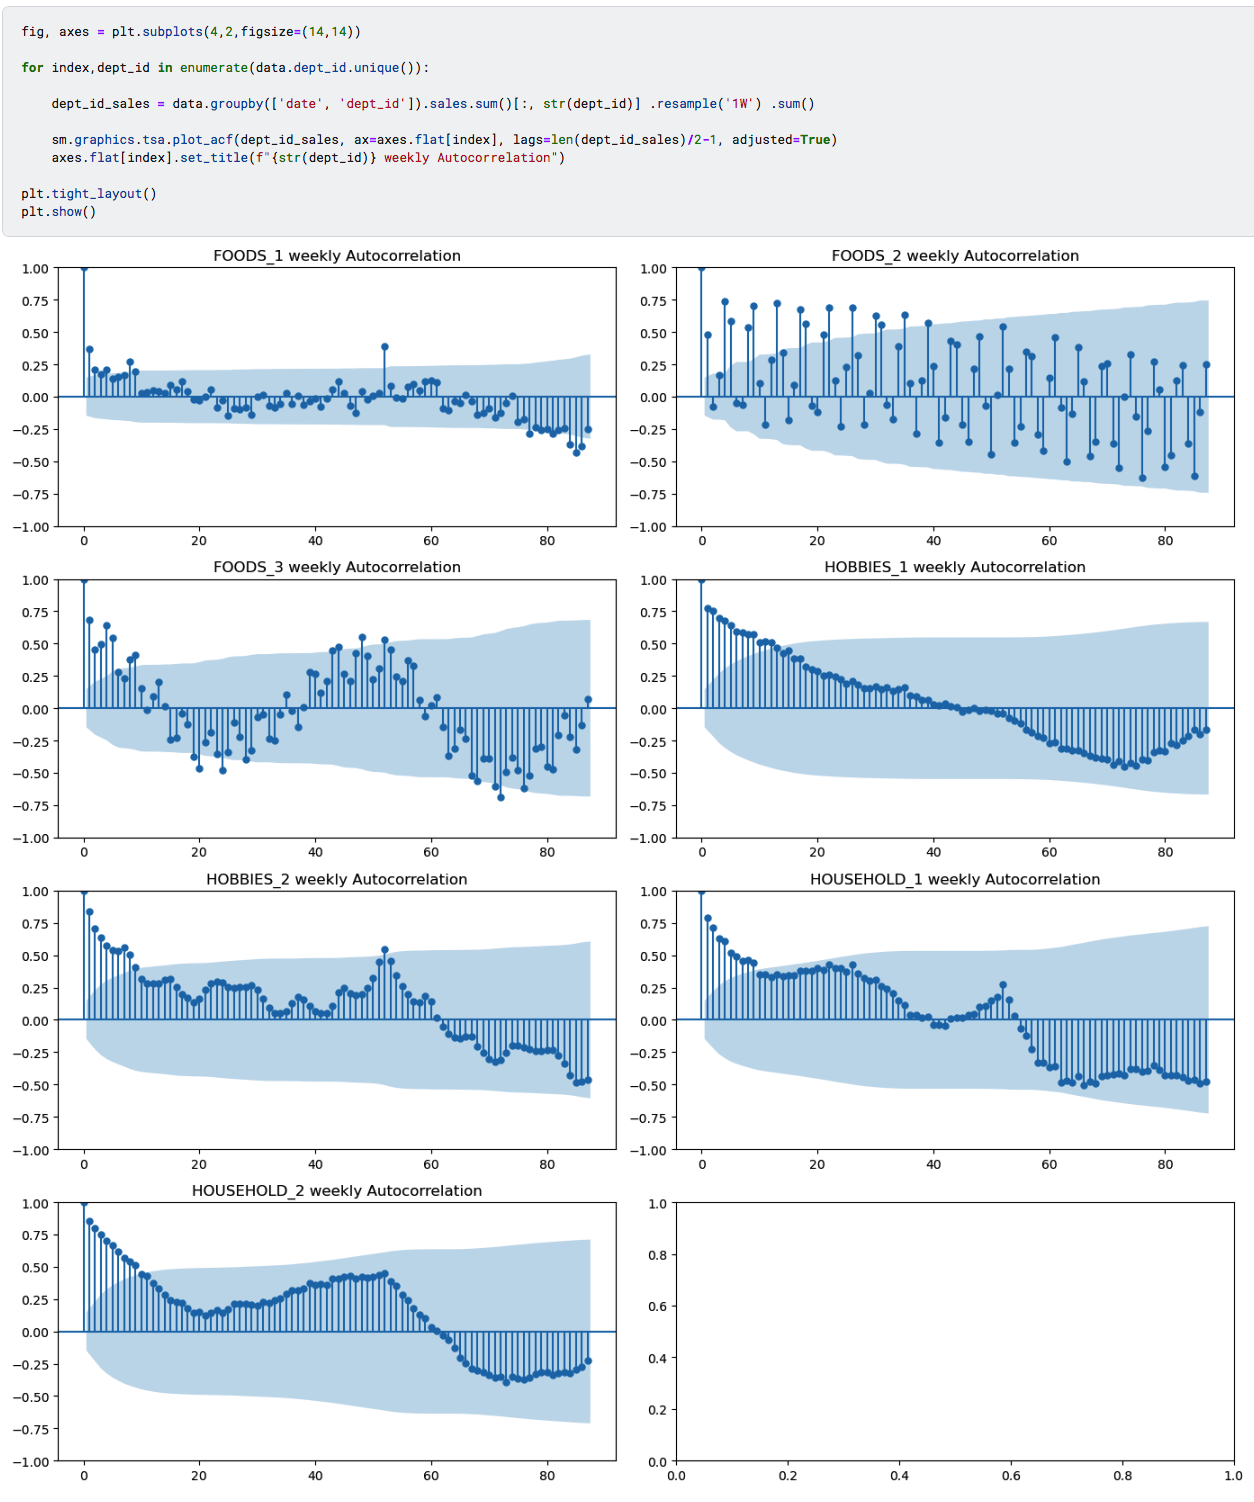

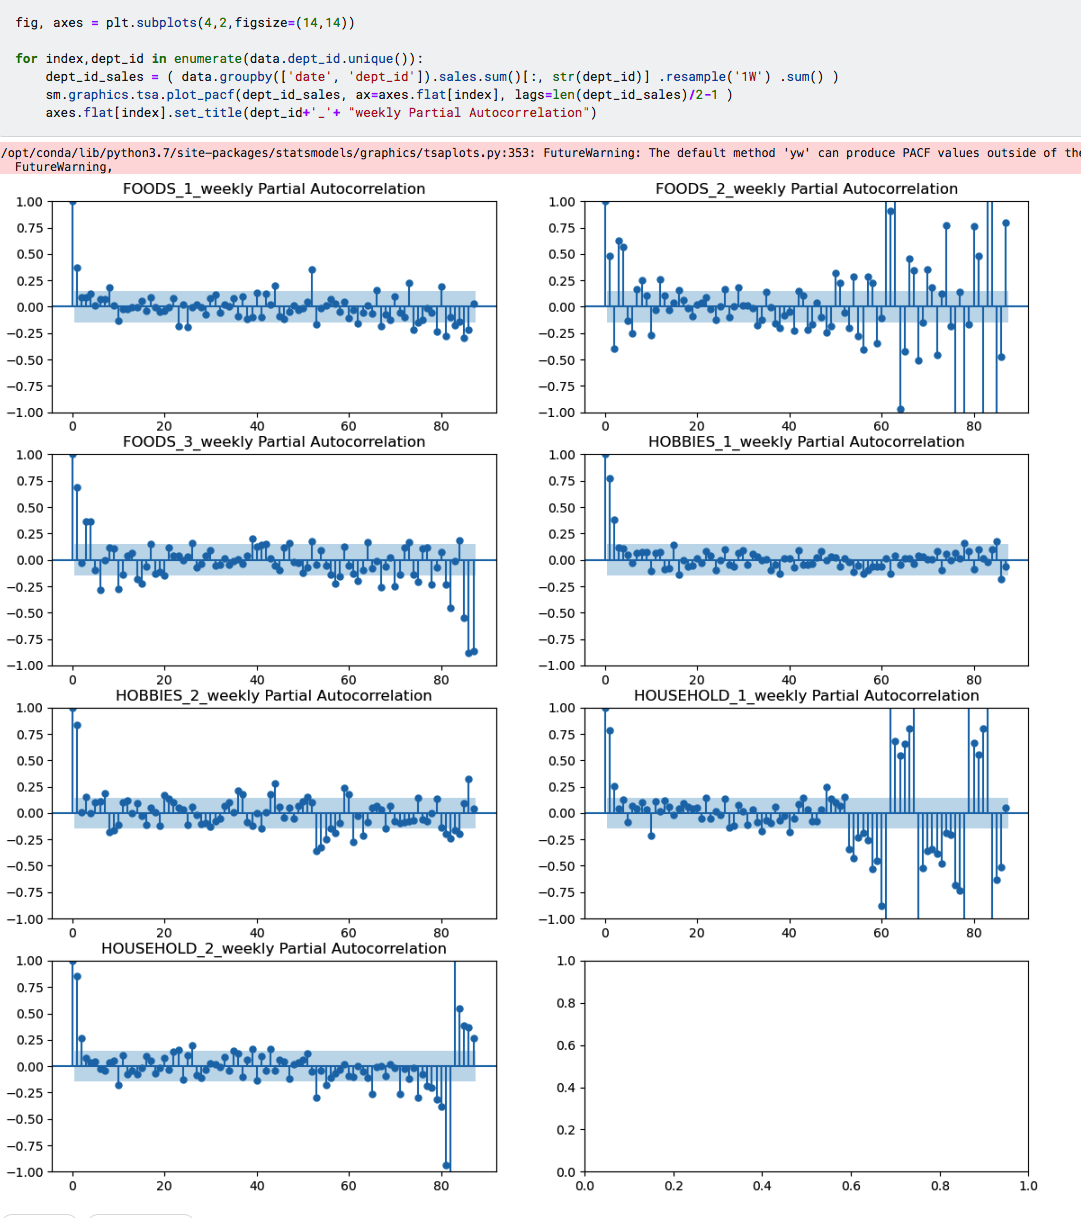

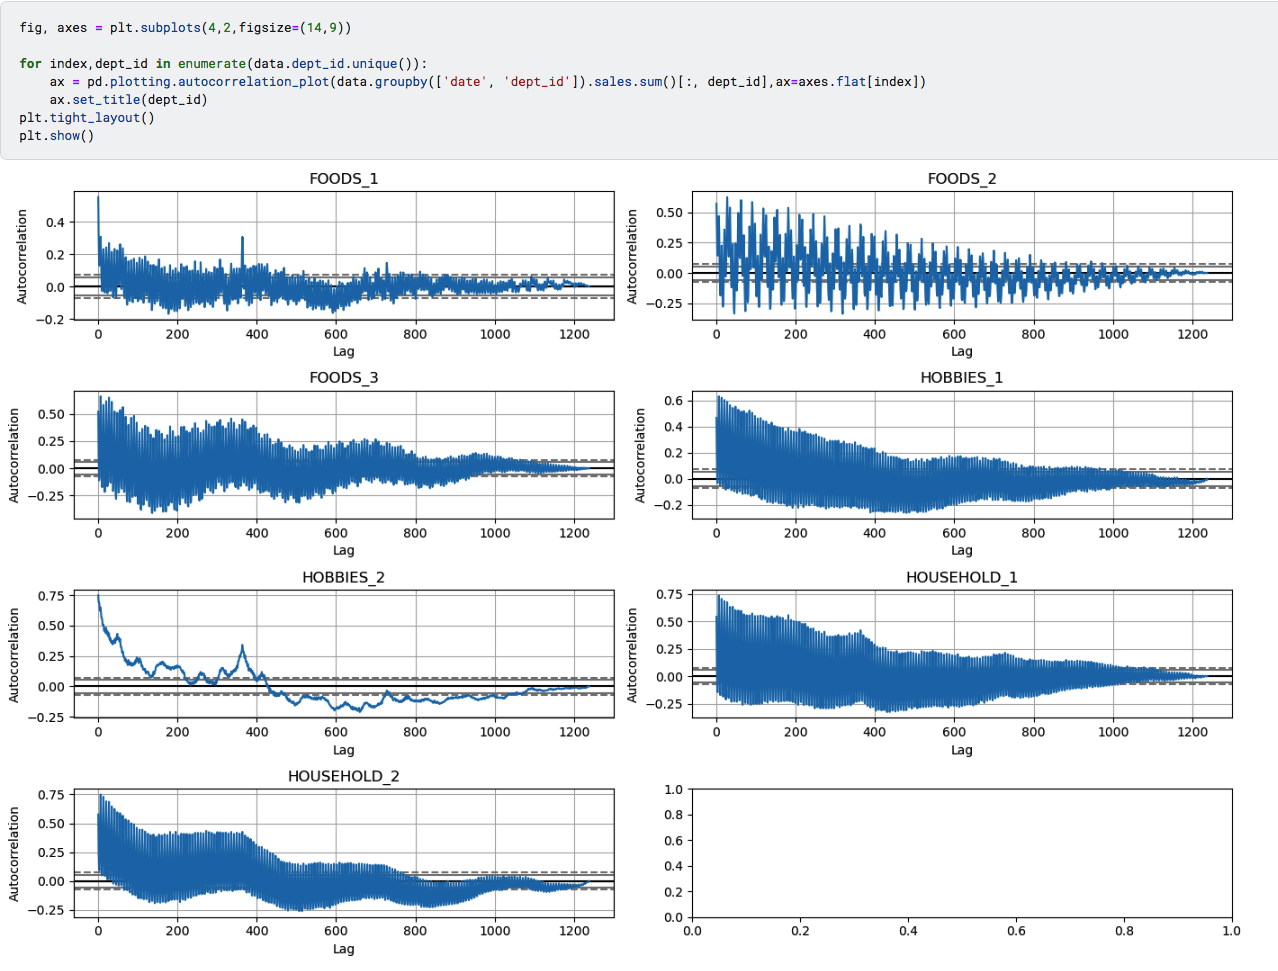

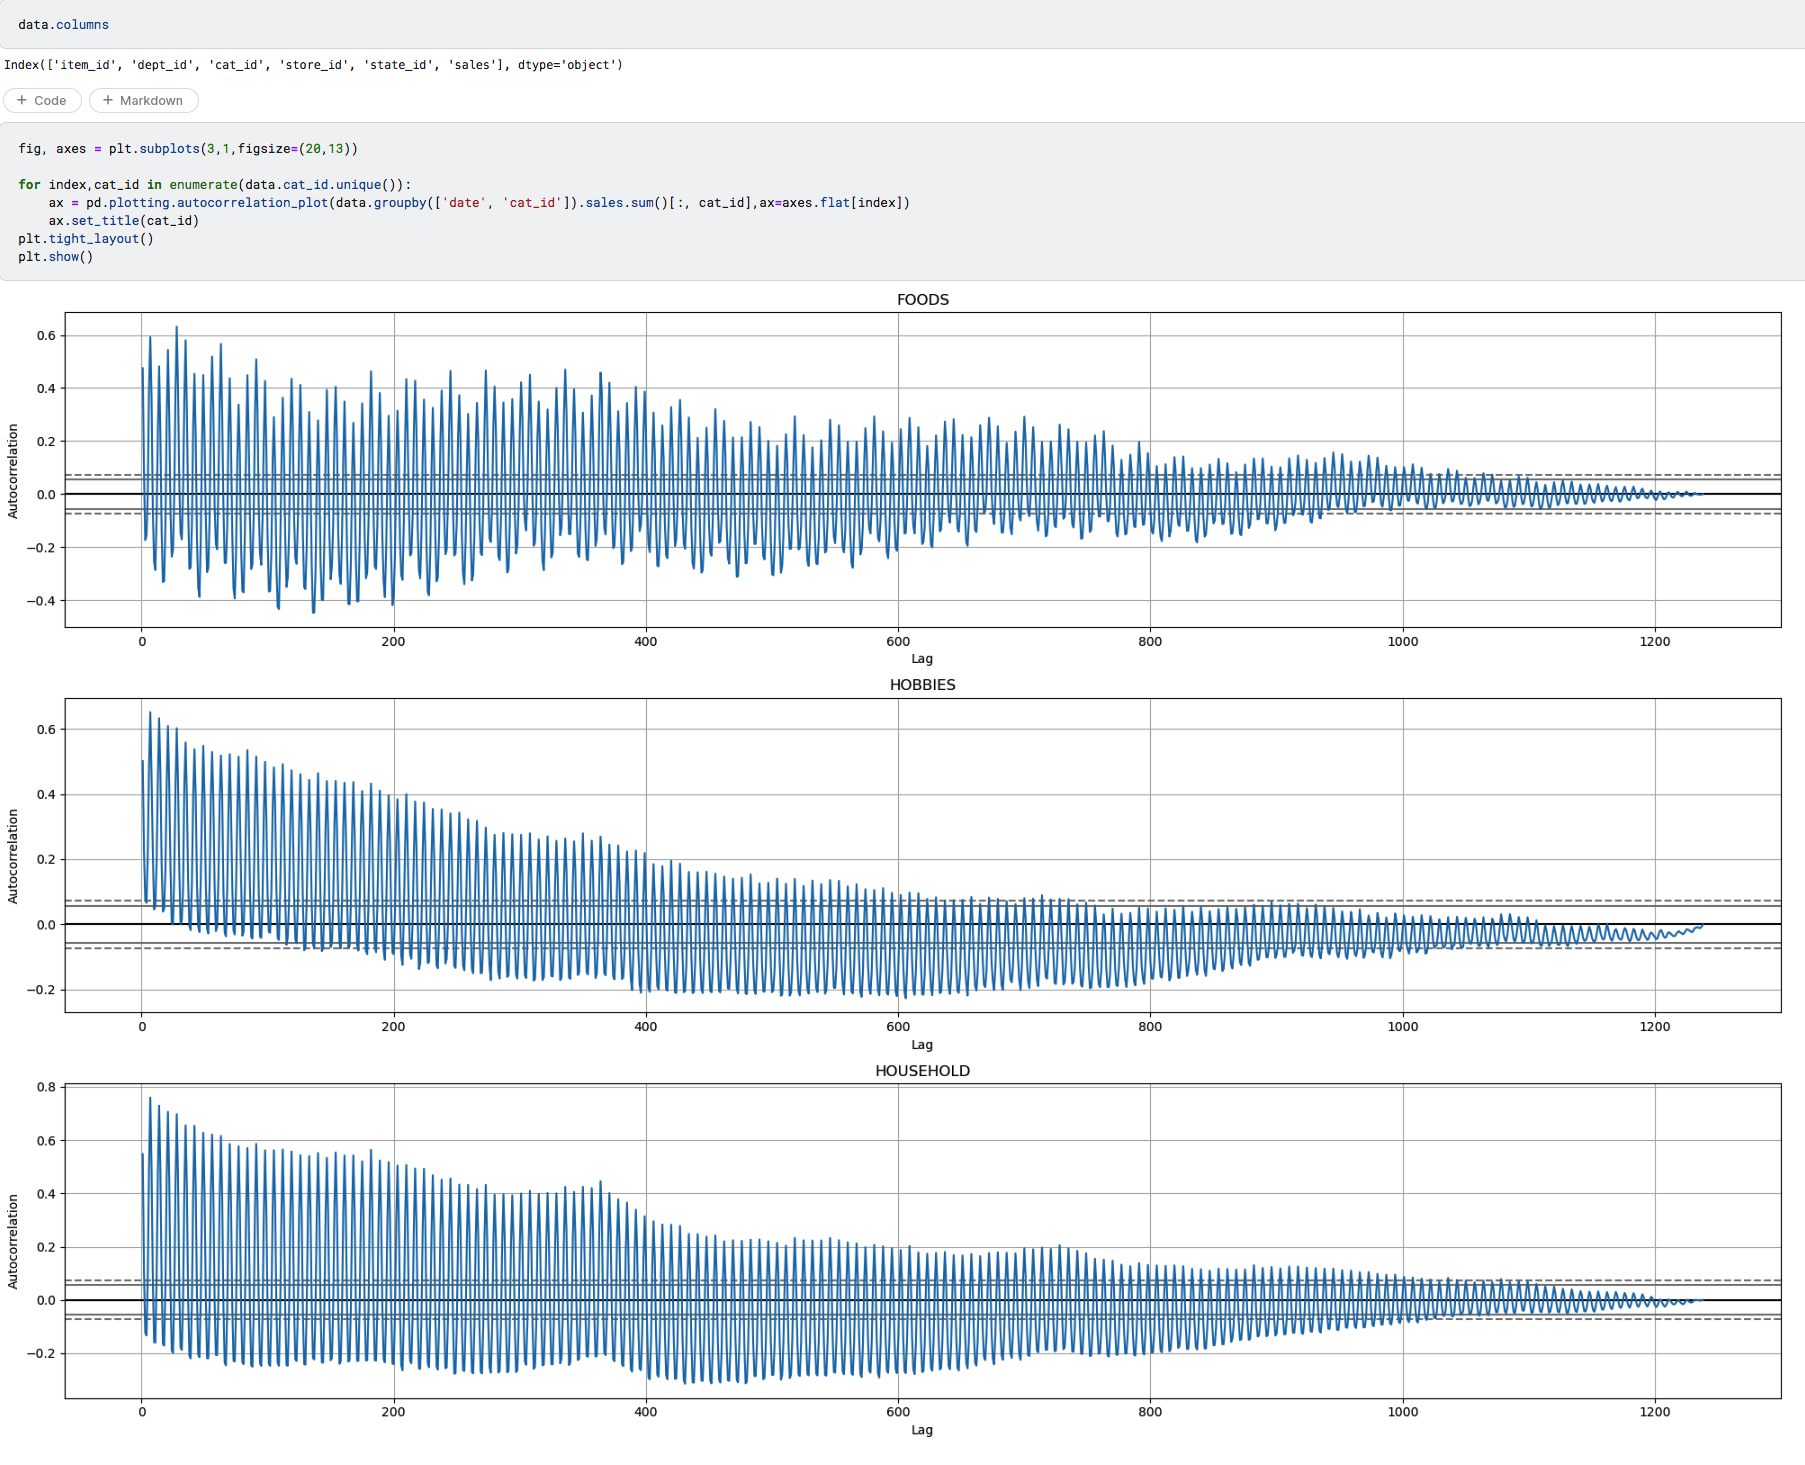

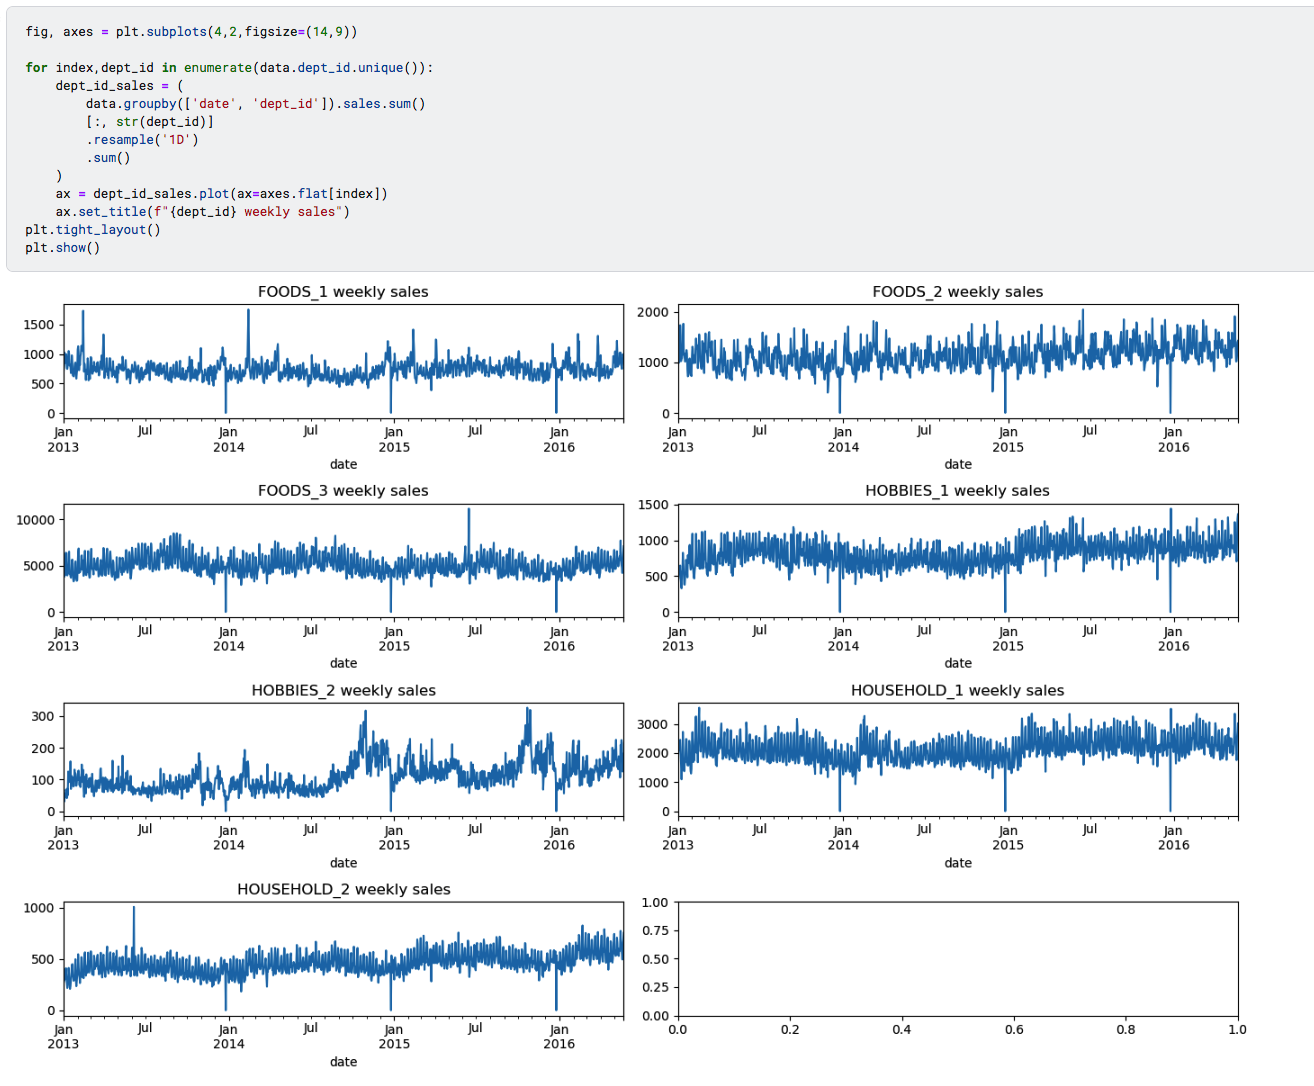

## Training some models!

Finally, we can train some models!

We're going to use the [statsforecast](https://github.com/Nixtla/statsforecast) library, since it makes training statistical time-series models really easy. There are other great libraries (like [darts](https://unit8co.github.io/darts/), which is more mature of a package) but I like `statsforecast` a bit more for these models. Eventually, we'll get to training our own models from scratch.

Here's what you need to do:

1. Aggregate sales up to the `date`/`dept_id` level so each date has 7 distinct records (one for each `dept_id`).
2. Convert your aggregated data into the [format that `statsforecast` likes](https://nixtla.github.io/statsforecast/examples/getting_started_short.html).
3. Fit and evaluate some models! This part is made straightforward by `statsforecast` so feel free to fit whatever you want, but focus on models like [this one](https://nixtla.github.io/statsforecast/models.html#arima-family) and [this one](https://nixtla.github.io/statsforecast/models.html#holt-winters-method) since we discussed them. Their documentation has a [quickstart](https://nixtla.github.io/statsforecast/examples/getting_started_short.html) to get going. I provided you with some helper code below to get started.
    - Play around with `ARIMA` and `HoltWinters` and tune them using your intution, then compare them to [`AutoARIMA`](https://nixtla.github.io/statsforecast/models.html#autoarima) and [`AutoETS`](https://nixtla.github.io/statsforecast/models.html#autoets), which do the tuning for you!
4. (If your time permits) try out other libraries! Go try to fit a [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) model, fit some models using `darts` and see how they compare, etc.

.

.

TRY PROPHET (SEE JAKUB and BRIAN TANI) AND ALSO PLAY WITH PREDICTION LIBRARIES
DO NOT WASTE THIS CLASS !!!

UNDERSTAND WHY MY OUTPUTS ABOVE ARE DIFFERENT THAN TIMO BOUZIAN (LEARN FROM HIS NB)
https://www.kaggle.com/jpbianchi/time-series-p1-timo-bouzian/edit

.

.

In [ ]:
# You'll see a lot of "WARNING: Retrying" outputs if you don't have internet enabled
# This happens because you haven't verified your phone number for your Kaggle profile.
# To do that, you'll need to exit the notebook, go to your profile, go to "account", and verify your phone number.
# Other than that, don't worry about any error outputs you see from this
! pip install statsforecast==1.5.0

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import ARIMA, HoltWinters

In [ ]:
# Aggregate data to date/dept_id level

train_data = data.groupby(['date', 'dept_id']).sales.agg('sum').reset_index()
train_data.head()

date dept_id   sales
0  2013-01-01       1  2905.0
1  2013-01-01       2  1199.0
2  2013-01-01       3  4230.0
3  2013-01-02       1  3278.0
4  2013-01-02       2  1317.0

In [ ]:
df = train_data.rename(columns={
                                'dept_id': 'unique_id',
                                'date': 'ds',
                                'sales': 'y'
                        })
train_df = df[df.ds < '2016-04-24']  #< pd.Timestamp('2016-04-24')]  my date is a string

sf = StatsForecast(
    models=[
        # SARIMA(1, 1, 1)(1, 1, 1),7
        ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1), season_length=7),
        # ETS model
        HoltWinters(season_length=7)
    ],
    freq='D'
)
sf.fit(train_df)

StatsForecast(models=[ARIMA,HoltWinters])

In [ ]:
forecast_df = sf.predict(h=28)
forecast_df.tail()

ds        ARIMA  HoltWinters
unique_id                                     
3         2016-05-17  4794.781738  4614.262695
3         2016-05-18  4695.505371  4536.413086
3         2016-05-19  4830.974609  4601.812500
3         2016-05-20  5074.104980  4978.221680
3         2016-05-21  6032.870117  6043.368652

These are `plotly` charts, which are interactive. If you're not familiar, you can:
- Click a series name in the legend (on the right) to activate/deactivate it in the plots
- Hover your mouse over the plots and click + drag to zoom in
- Double click on the plots to zoom back out

In [ ]:
sf.plot(df, forecast_df)

In [ ]:
# from jacob figura  https://www.kaggle.com/jpbianchi/jakub-figura-project-1/edit
forecast_prophet_full = pd.DataFrame()

for i, dept in enumerate(departments):

    model = Prophet(
                    seasonality_mode='multiplicative',
                    weekly_seasonality=True,
                    yearly_seasonality=4,
                    changepoint_prior_scale=0.05
                    )

    model.add_seasonality(
    name='monthly',
    period=365.25/12,
    fourier_order=4,
    mode='multiplicative'
    )


    model.fit(train_df[train_df['unique_id'] == dept])

    future = model.make_future_dataframe(periods=28)

    forecast = model.predict(future)

    forecast['unique_id'] = dept

    forecast = forecast[-28:][['unique_id','ds','yhat']]
    forecast.rename(columns = {'yhat':'Prophet'}, inplace = True)

    forecast_prophet_full = pd.concat([forecast,forecast_prophet_full],axis = 0)

forecast_prophet_full

forecast_df = pd.merge(forecast_df.reset_index(),forecast_prophet_full, on =['unique_id','ds'])

train_df = train_df.set_index(['ds','unique_id'])
test_df = test_df.set_index(['ds','unique_id'])
forecast_df = forecast_df.set_index(['ds','unique_id'])

sns.set_style('whitegrid')

test_min_date = test_df.index.get_level_values(0).min()
rmse_full = pd.DataFrame()

for i, dep in enumerate(departments):

    train_aux = train_df.loc[pd.IndexSlice['2016-02-01':, dep],:]
    test_aux = test_df.loc[pd.IndexSlice[:, dep],:]
    forecast_aux = forecast_df.loc[pd.IndexSlice[:, dep],:]

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(data=train_aux, x = train_aux.index.get_level_values(0), y = 'y', color = 'lightsteelblue', ax = ax, label = 'train')
    sns.lineplot(data=test_aux, x = test_aux.index.get_level_values(0), y = 'y', color = 'grey', ax = ax, label = 'test')
    ax.axvline(x=test_min_date, color='r', linestyle='--')

    for model in forecast_df.columns:
        sns.lineplot(data=forecast_aux, x = forecast_aux.index.get_level_values(0), y = model, ax = ax, label = model)

        rmse = pd.DataFrame()
        rmse['RMSE'] = pd.Series(np.sqrt(mean_squared_error(test_aux['y'].head(28), forecast_aux[model])))
        rmse['model'] = model
        rmse['unique_id'] = dep
        rmse_full = pd.concat([rmse,rmse_full],axis = 0)

    ax.set_title('Department: {}'.format(dep))


    leg_ax = ax
    ax = plt.gca()

    leg_ax.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))

rmse_full.pivot(columns = 'model', index = 'unique_id').round(2)

In [ ]:
# from brian tani https://www.kaggle.com/code/jpbianchi/brian-tani-notebook/edit/run/122503463

!pip install prophet
!pip install sktime

from prophet import Prophet

def run_prophet(df, forecast_df):
    fdf = forecast_df.reset_index()
    results = []
    for dept_id in df.unique_id.unique():
        d = df[df.unique_id == dept_id][['ds','y']]
        m = Prophet(
            changepoint_prior_scale=0.5
        )
        m.add_seasonality(
            name='weekly', period=7, fourier_order=5, prior_scale=10
        )
        m.add_seasonality(
            name='monthly', period=30.5,fourier_order=5, prior_scale=10
        )
        m.add_country_holidays(country_name='US')
        m.fit(d)

        future = m.make_future_dataframe(periods=28)
        forecast = m.predict(future)
        fdf.loc[fdf['unique_id']==dept_id, 'Prophet'] = forecast['yhat'].tail(28).to_numpy()

        results.append((dept_id, m, forecast))
    return results, fdf

  results, fdf = run_prophet(train_df, forecast_df)

  fdf.describe()

  from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as mape
from sktime.performance_metrics.forecasting import mean_absolute_error as mae
from sktime.performance_metrics.forecasting import mean_squared_error as mse

def rmse(*args, **kwargs):
    return np.sqrt(mse(*args, **kwargs))

metrics_func = {
    "mae": mae,
    "rmse": rmse,
    "mape": mape
}

def run_metrics(df, forecast_df):
    metrics_df_list = []
    merged_df = (
        df.merge(
            forecast_df,
            on=['ds','unique_id']
        )
    )

    for dept_id in df.unique_id.unique():
        d = merged_df[merged_df.unique_id == dept_id]
        metrics_df = pd.DataFrame(
            columns=[col for col in forecast_df.columns if not col in ['ds','y','unique_id']],
            index=list(metrics_func.keys())
        )
        for metric in metrics_df.index:
            for model in metrics_df.columns:
                try:
                    metrics_df.loc[metric, model] = metrics_func[metric](d['y'], d[model])
                except:
                    metrics_df.loc[metric, model] = np.nan
        print(f"{dept_id} Metrics")
        display(metrics_df)
        metrics_df_list.append(metrics_df)
    return metrics_df_list

metrics = run_metrics(df, fdf)

sf.plot(df, fdf)

from prophet.plot import plot_plotly, plot_components_plotly

# for dept_id, model, forecast in results:
#    fig = plot_plotly(model, forecast)
#    fig.update_layout(title=f"{dept_id} prophet model")
#    display(fig)

# for dept_id, model, forecast in results:
#    fig = plot_components_plotly(model, forecast)
#    fig.update_layout(title=f"{dept_id} prophet model components")
#    display(fig)